## Initial imports

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

pd.set_option('display.max_columns', None)

In [2]:
bank_df = pd.read_csv(os.path.join('data', 'Bank.csv'), index_col=0)
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,deposit
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,yes
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,yes


In order to model the dependant variable `deposit` we need to model as a 0-1 problem

In [3]:
bank_df['deposit'] = bank_df['deposit'].map({'yes': 1, 'no': 0})
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,deposit
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


We need to engineer a feture for 'was not previously contacted' which is represented with `pdays` = 999

In [4]:
bank_df['client_was_contacted'] = np.where(bank_df['pdays'] == 999, 0, 1)
bank_df['pdays'] = np.where(bank_df['pdays'] == 999, 0, bank_df['pdays'])
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,deposit,client_was_contacted
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,0,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,0,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,0,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1,1


## Logistic Regression

We  need to do an information value calculation to determine the predictive ability of each independent variable. For text data we will model as a categorical while numerical data will be modelled as continuous. Continuous data will be binned into 10 parts for analysis.

In [5]:
def info_value_calc(df, column, is_categorical):
    # in this case we have categorical data that we will bin using their values
    if is_categorical:
        info_val_df = df.groupby([column])['deposit'].agg(['count', 'sum']) 
    # in this case we have continuous data (integers, floats, etc.) that we will bin into deciles for data normalization
    else:
        df['variable_bin'] = pd.qcut(df[column].rank(method='first'), 10)
        info_val_df = df.groupby(['variable_bin'])['deposit'].agg(['count', 'sum'])
    
    info_val_df = info_val_df.rename(columns={'sum': 'bad'})
    info_val_df["good"] = info_val_df["count"] - info_val_df["bad"]
    info_val_df["bad_percentage"] = info_val_df["bad"] / info_val_df["bad"].sum()
    info_val_df["good_percentage"] = info_val_df["good"] / info_val_df["good"].sum()
    info_val_df["information_value"] = info_val_df.apply(lambda row: (row['good_percentage'] - row['bad_percentage']) * (np.log(row["good_percentage"] / row["bad_percentage"]) if row["bad_percentage"] != 0.0 else 1.0), axis=1)
    return info_val_df

This is a sample of the information value calculation for education level

In [6]:
print(info_value_calc(bank_df, 'education', True))
print('Total information value: ' + str(info_value_calc(bank_df, 'education', True)['information_value'].sum()))

                     count   bad   good  bad_percentage  good_percentage  \
education                                                                  
basic.4y              4176   428   3748        0.092241         0.102550   
basic.6y              2292   188   2104        0.040517         0.057568   
basic.9y              6045   473   5572        0.101940         0.152457   
high.school           9515  1031   8484        0.222198         0.232133   
illiterate              18     4     14        0.000862         0.000383   
professional.course   5243   595   4648        0.128233         0.127175   
university.degree    12168  1670  10498        0.359914         0.287239   
unknown               1731   251   1480        0.054095         0.040495   

                     information_value  
education                               
basic.4y                      0.001092  
basic.6y                      0.005989  
basic.9y                      0.020333  
high.school                   0.00

We now need to perform an information value calculation on each column to determine its predictive ability

$\textrm{Information Value} = ln\left(\frac{\textrm{% good}}{\textrm{% bad}}\right)*(\textrm{% good} - \textrm{% bad}) $

In [7]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 
                       'campaign', 'poutcome', 'client_was_contacted']
continuous_columns = ['age', 'duration', 'pdays', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 
                     'nr_employed', 'previous']
information_value_list = []

for column in categorical_columns:
    information_value_df = info_value_calc(bank_df, column, True)
    information_value = information_value_df['information_value'].sum()
    information_value_list.append({'information_value': information_value, 'column': column})
    
for column in continuous_columns:
    information_value_df = info_value_calc(bank_df, column, False)
    information_value = information_value_df['information_value'].sum()
    information_value_list.append({'information_value': information_value, 'column': column})
    
information_value_df = pd.DataFrame(information_value_list)
information_value_df = information_value_df.sort_values(by=['information_value'], ascending=False)
print(information_value_df)

    information_value                column
13           1.961060              duration
19           1.092445           nr_employed
18           1.059292             euribor3m
15           0.777944          emp_var_rate
17           0.622916         cons_conf_idx
11           0.551306  client_was_contacted
10           0.547671              poutcome
7            0.485117                 month
16           0.449511        cons_price_idx
20           0.261490              previous
6            0.251663               contact
14           0.244849                 pdays
0            0.188713                   job
3            0.127851               default
12           0.127037                   age
9            0.063208              campaign
2            0.048576             education
1            0.028215               marital
8            0.006493           day_of_week
4            0.001383               housing
5            0.000269                  loan


We will continue with the top 15 variables by predictive power. Next we will construct dummy variables for `categorical` data types.

In [8]:
client_contacted_dummies = pd.get_dummies(bank_df['client_was_contacted'], prefix='client_was_contacted')
poutcome_dummies = pd.get_dummies(bank_df['poutcome'], prefix='poutcome')
month_dummies = pd.get_dummies(bank_df['month'], prefix='month')
contact_dummies = pd.get_dummies(bank_df['contact'], prefix='contact')
job_dummies = pd.get_dummies(bank_df['job'], prefix='job')
default_dummies = pd.get_dummies(bank_df['default'], prefix='default')

bank_model_df = pd.concat([bank_df[['duration', 'nr_employed', 'euribor3m', 'emp_var_rate', 'cons_conf_idx', 'cons_price_idx', 'deposit', 
                                   'pdays', 'age', 'previous']],
                          client_contacted_dummies, poutcome_dummies, month_dummies, 
                          contact_dummies, job_dummies, default_dummies], axis=1)
bank_model_df.head()

,duration,nr_employed,euribor3m,emp_var_rate,cons_conf_idx,cons_price_idx,deposit,pdays,age,previous,client_was_contacted_0,client_was_contacted_1,poutcome_failure,poutcome_nonexistent,poutcome_success,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,contact_cellular,contact_telephone,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,default_no,default_unknown,default_yes
0,210,5228.1,4.963,1.4,-36.1,93.444,0,0,44,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,138,5195.8,4.021,-0.1,-42.0,93.200,0,0,53,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,339,4991.6,0.729,-1.7,-39.8,94.055,1,6,28,2,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,185,5099.1,1.405,-1.8,-47.1,93.075,0,0,39,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,137,5076.2,0.869,-2.9,-31.4,92.201,1,3,55,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [9]:
x_train, x_test, y_train, y_test = train_test_split(bank_model_df.drop(['deposit'] ,axis=1), 
                                                    bank_model_df['deposit'],
                                                    train_size=0.7, # 70-30 split
                                                    random_state=42) # constant seed allows for reproducability
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

We have to remove the excess dummy variables that pandas creates with `pd.get_dummies`.

In [10]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

         Current function value: 0.202419
         Iterations: 1000
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28795
Method:                           MLE   Df Model:                           35
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4210
Time:                        19:13:58   Log-Likelihood:                -5836.0
converged:                      False   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -288.6847     46.823     -6.165      0.000    -380.455    -196.914
duration                   

C:\tools\Anaconda3\envs\bank-analysis\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We need to check the variance inflation factor of these variables to check for multi-collinearity

In [11]:
variance_inflation_list = []
variables = pd.Series(x_train.drop(columns_to_drop, axis=1).columns)
completed_cols = []
variance_inflation_factors = []

for variable in variables:
    completed_cols.append(variable)
    dependent_variable = variable
    independent_variables = variables[~variables.isin(completed_cols)]
    mod = sm.OLS(x_train.drop(columns_to_drop, axis=1)[dependent_variable], sm.add_constant(x_train.drop(columns_to_drop, axis=1)[independent_variables.to_list()]))
    residuals = mod.fit()
    variance_inflation_factor = 1 / (1 - residuals.rsquared)
    variance_inflation_factors.append({'dependent_variable': dependent_variable, 'variance_inflation_factor': variance_inflation_factor})
    
print(pd.DataFrame(variance_inflation_factors))

        dependent_variable  variance_inflation_factor
0                 duration                   1.011601
1              nr_employed                 199.199988
2                euribor3m                 104.090973
3             emp_var_rate                   7.440831
4            cons_conf_idx                   2.220549
5           cons_price_idx                   2.621768
6                    pdays                   3.963402
7                      age                   1.405326
8                 previous                   5.568172
9   client_was_contacted_0                  11.033087
10        poutcome_failure                   1.157539
11        poutcome_success                   1.073545
12               month_aug                   2.925225
13               month_dec                   1.024404
14               month_jul                   1.522485
15               month_jun                   1.601930
16               month_mar                   1.021689
17               month_may  

We have to determine how well the classifier is doing at predicting results. We will use the c-statistic for this.

$\textrm{% concordant pairs} = \frac{\textrm{Number of Concordant pairs}}{\textrm{Total pairs}}$

$\textrm{% discordant pairs} = \frac{\textrm{Number of Discordant pairs}}{\textrm{Total pairs}}$

$\textrm{% tied pairs} = \frac{\textrm{Number of Tied pairs}}{\textrm{Total pairs}}$

$\textrm{c statistic} = 0.5 + \frac{(\textrm{% Concordant pairs - % Discordant pairs})}{2}$

In [12]:
def df_crossjoin(df1, df2, **kwargs):
    df1['temp_key'] = 1
    df2['temp_key'] = 1
    return_df = pd.merge(df1, df2, on='temp_key', **kwargs).drop('temp_key', axis=1)
    return_df.index = pd.MultiIndex.from_product((df1.index, df2.index))
    return return_df

In [13]:
y_prediction = pd.DataFrame(logistic_model.predict(sm.add_constant(x_train.drop(columns_to_drop, axis=1))))
y_prediction.columns = ["probabilities"]
both_df = pd.concat([y_train, y_prediction], axis=1)
zeros_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 0]
ones_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 1]
joined_df = df_crossjoin(ones_df, zeros_df)
joined_df['concordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] > joined_df['probabilities_y'], 'concordant_pair'] = 1
joined_df['discordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] < joined_df['probabilities_y'], 'discordant_pair'] = 1
joined_df['tied_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] == joined_df['probabilities_y'], 'tied_pair'] = 1
p_concordant = (sum(joined_df['concordant_pair']) * 1.0 ) / (joined_df.shape[0])
p_discordant = (sum(joined_df['discordant_pair']) * 1.0 ) / (joined_df.shape[0])
c_statistic = 0.5 + (p_concordant - p_discordant) / 2.0
print("C-statistic: " + str(c_statistic))

C-statistic: 0.9385172268269756


Our c-statistic is > 0.7 which is an extremely strong model however we need to address the variables that are multi-colinear and that do not have strong explanitory power. This now becomes an iterative process where we remove variables with a high p-value and a high variance inflation factor while trying to maintain a strong c-statistic. We will start by eliminating `default_yes` and rerunning the process again.

In [14]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202420
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28796
Method:                           MLE   Df Model:                           34
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4210
Time:                        19:14:26   Log-Likelihood:                -5836.0
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -288.6970     46.823     -6.166      0.000    -380.468    -

We now remove `job_unemployed`

In [15]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202422
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28797
Method:                           MLE   Df Model:                           33
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4210
Time:                        19:14:26   Log-Likelihood:                -5836.0
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -288.5897     46.819     -6.164      0.000    -380.354    -

We now remove `job_services`

In [16]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202425
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28798
Method:                           MLE   Df Model:                           32
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4210
Time:                        19:14:26   Log-Likelihood:                -5836.1
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -288.6046     46.815     -6.165      0.000    -380.359    -

We can now remove `previous`

In [17]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202435
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28799
Method:                           MLE   Df Model:                           31
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4209
Time:                        19:14:26   Log-Likelihood:                -5836.4
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -287.9096     46.823     -6.149      0.000    -379.680    -

We now remove `pdays`

In [18]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202441
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28800
Method:                           MLE   Df Model:                           30
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4209
Time:                        19:14:26   Log-Likelihood:                -5836.6
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -288.6002     46.814     -6.165      0.000    -380.354    -

We now remove `job_entrepreneur `

In [19]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202452
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28801
Method:                           MLE   Df Model:                           29
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4209
Time:                        19:14:27   Log-Likelihood:                -5836.9
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -288.7404     46.811     -6.168      0.000    -380.488    -

We now remove `job_housemaid `

In [20]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202464
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28802
Method:                           MLE   Df Model:                           28
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4209
Time:                        19:14:27   Log-Likelihood:                -5837.2
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -288.0357     46.805     -6.154      0.000    -379.771    -

We now remove `job_unknown`

In [21]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202474
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28803
Method:                           MLE   Df Model:                           27
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4208
Time:                        19:14:27   Log-Likelihood:                -5837.5
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -288.0765     46.809     -6.154      0.000    -379.820    -

We now remove `month_oct`

In [22]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202485
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28804
Method:                           MLE   Df Model:                           26
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4208
Time:                        19:14:27   Log-Likelihood:                -5837.8
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -269.0830     40.395     -6.661      0.000    -348.256    -1

We now remove `age`

In [23]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct', 'age']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202503
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28805
Method:                           MLE   Df Model:                           25
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4207
Time:                        19:14:28   Log-Likelihood:                -5838.4
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -267.0590     40.346     -6.619      0.000    -346.136    -1

We now remove `month_dec`

In [24]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct', 'age', 'month_dec']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202528
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28806
Method:                           MLE   Df Model:                           24
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4207
Time:                        19:14:28   Log-Likelihood:                -5839.1
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -260.2541     39.921     -6.519      0.000    -338.498    -1

We now remove `month_jul`

In [25]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct', 'age', 'month_dec', 'month_jul']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202556
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28807
Method:                           MLE   Df Model:                           23
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4206
Time:                        19:14:28   Log-Likelihood:                -5839.9
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -275.6509     38.033     -7.248      0.000    -350.195    -2

We now remove `job_blue-collar`

In [26]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct', 'age', 'month_dec', 'month_jul', 'job_blue-collar']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202600
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28808
Method:                           MLE   Df Model:                           22
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4205
Time:                        19:14:28   Log-Likelihood:                -5841.2
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -275.8813     38.042     -7.252      0.000    -350.442    -2

At this point we are only left with explanitory variables but we still have to check multi-collinearity

In [27]:
variance_inflation_list = []
variables = pd.Series(x_train.drop(columns_to_drop, axis=1).columns)
completed_cols = []
variance_inflation_factors = []

for variable in variables:
    completed_cols.append(variable)
    dependent_variable = variable
    independent_variables = variables[~variables.isin(completed_cols)]
    mod = sm.OLS(x_train.drop(columns_to_drop, axis=1)[dependent_variable], sm.add_constant(x_train.drop(columns_to_drop, axis=1)[independent_variables.to_list()]))
    residuals = mod.fit()
    variance_inflation_factor = 1 / (1 - residuals.rsquared)
    variance_inflation_factors.append({'dependent_variable': dependent_variable, 'variance_inflation_factor': variance_inflation_factor})
    
print(pd.DataFrame(variance_inflation_factors))

        dependent_variable  variance_inflation_factor
0                 duration                   1.010394
1              nr_employed                 146.492249
2                euribor3m                 102.370239
3             emp_var_rate                   5.836826
4            cons_conf_idx                   1.867593
5           cons_price_idx                   2.095633
6   client_was_contacted_0                  10.997748
7         poutcome_failure                   1.117586
8         poutcome_success                   1.051492
9                month_aug                   1.385424
10               month_jun                   1.581854
11               month_mar                   1.019970
12               month_may                   1.197116
13               month_nov                   1.050088
14               month_sep                   1.012863
15       contact_telephone                   1.029174
16              job_admin.                   1.201458
17          job_management  

We will drop `nr_employed` and rerun the model

In [28]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct', 'age', 'month_dec', 'month_jul', 'job_blue-collar', 'nr_employed']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.202700
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28809
Method:                           MLE   Df Model:                           21
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4202
Time:                        19:14:29   Log-Likelihood:                -5844.0
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -189.7745     11.935    -15.901      0.000    -213.166    -1

In [29]:
variance_inflation_list = []
variables = pd.Series(x_train.drop(columns_to_drop, axis=1).columns)
completed_cols = []
variance_inflation_factors = []

for variable in variables:
    completed_cols.append(variable)
    dependent_variable = variable
    independent_variables = variables[~variables.isin(completed_cols)]
    mod = sm.OLS(x_train.drop(columns_to_drop, axis=1)[dependent_variable], sm.add_constant(x_train.drop(columns_to_drop, axis=1)[independent_variables.to_list()]))
    residuals = mod.fit()
    variance_inflation_factor = 1 / (1 - residuals.rsquared)
    variance_inflation_factors.append({'dependent_variable': dependent_variable, 'variance_inflation_factor': variance_inflation_factor})
    
print(pd.DataFrame(variance_inflation_factors))

        dependent_variable  variance_inflation_factor
0                 duration                   1.010304
1                euribor3m                 102.370239
2             emp_var_rate                   5.836826
3            cons_conf_idx                   1.867593
4           cons_price_idx                   2.095633
5   client_was_contacted_0                  10.997748
6         poutcome_failure                   1.117586
7         poutcome_success                   1.051492
8                month_aug                   1.385424
9                month_jun                   1.581854
10               month_mar                   1.019970
11               month_may                   1.197116
12               month_nov                   1.050088
13               month_sep                   1.012863
14       contact_telephone                   1.029174
15              job_admin.                   1.201458
16          job_management                   1.025359
17             job_retired  

In [30]:
y_prediction = pd.DataFrame(logistic_model.predict(sm.add_constant(x_train.drop(columns_to_drop, axis=1))))
y_prediction.columns = ["probabilities"]
both_df = pd.concat([y_train, y_prediction], axis=1)
zeros_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 0]
ones_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 1]
joined_df = df_crossjoin(ones_df, zeros_df)
joined_df['concordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] > joined_df['probabilities_y'], 'concordant_pair'] = 1
joined_df['discordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] < joined_df['probabilities_y'], 'discordant_pair'] = 1
joined_df['tied_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] == joined_df['probabilities_y'], 'tied_pair'] = 1
p_concordant = (sum(joined_df['concordant_pair']) * 1.0 ) / (joined_df.shape[0])
p_discordant = (sum(joined_df['discordant_pair']) * 1.0 ) / (joined_df.shape[0])
c_statistic = 0.5 + (p_concordant - p_discordant) / 2.0
print("C-statistic: " + str(c_statistic))

C-statistic: 0.9383863376935029


We will now drop `euribor3m`

In [31]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct', 'age', 'month_dec', 'month_jul', 'job_blue-collar', 'nr_employed', 'euribor3m']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.203417
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28810
Method:                           MLE   Df Model:                           20
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4181
Time:                        19:14:58   Log-Likelihood:                -5864.7
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -124.8097      6.365    -19.610      0.000    -137.284    -1

In [32]:
variance_inflation_list = []
variables = pd.Series(x_train.drop(columns_to_drop, axis=1).columns)
completed_cols = []
variance_inflation_factors = []

for variable in variables:
    completed_cols.append(variable)
    dependent_variable = variable
    independent_variables = variables[~variables.isin(completed_cols)]
    mod = sm.OLS(x_train.drop(columns_to_drop, axis=1)[dependent_variable], sm.add_constant(x_train.drop(columns_to_drop, axis=1)[independent_variables.to_list()]))
    residuals = mod.fit()
    variance_inflation_factor = 1 / (1 - residuals.rsquared)
    variance_inflation_factors.append({'dependent_variable': dependent_variable, 'variance_inflation_factor': variance_inflation_factor})
    
print(pd.DataFrame(variance_inflation_factors))

        dependent_variable  variance_inflation_factor
0                 duration                   1.010276
1             emp_var_rate                   5.836826
2            cons_conf_idx                   1.867593
3           cons_price_idx                   2.095633
4   client_was_contacted_0                  10.997748
5         poutcome_failure                   1.117586
6         poutcome_success                   1.051492
7                month_aug                   1.385424
8                month_jun                   1.581854
9                month_mar                   1.019970
10               month_may                   1.197116
11               month_nov                   1.050088
12               month_sep                   1.012863
13       contact_telephone                   1.029174
14              job_admin.                   1.201458
15          job_management                   1.025359
16             job_retired                   1.009973
17             job_student  

In [33]:
y_prediction = pd.DataFrame(logistic_model.predict(sm.add_constant(x_train.drop(columns_to_drop, axis=1))))
y_prediction.columns = ["probabilities"]
both_df = pd.concat([y_train, y_prediction], axis=1)
zeros_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 0]
ones_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 1]
joined_df = df_crossjoin(ones_df, zeros_df)
joined_df['concordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] > joined_df['probabilities_y'], 'concordant_pair'] = 1
joined_df['discordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] < joined_df['probabilities_y'], 'discordant_pair'] = 1
joined_df['tied_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] == joined_df['probabilities_y'], 'tied_pair'] = 1
p_concordant = (sum(joined_df['concordant_pair']) * 1.0 ) / (joined_df.shape[0])
p_discordant = (sum(joined_df['discordant_pair']) * 1.0 ) / (joined_df.shape[0])
c_statistic = 0.5 + (p_concordant - p_discordant) / 2.0
print("C-statistic: " + str(c_statistic))

C-statistic: 0.9372719672994454


We now remove `client_was_contacted_0`

In [34]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct', 'age', 'month_dec', 'month_jul', 'job_blue-collar', 'nr_employed', 'euribor3m', 'client_was_contacted_0']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.203606
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28811
Method:                           MLE   Df Model:                           19
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4176
Time:                        19:15:34   Log-Likelihood:                -5870.2
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -127.1946      6.316    -20.139      0.000    -139.573    -114.816
duration

In [35]:
variance_inflation_list = []
variables = pd.Series(x_train.drop(columns_to_drop, axis=1).columns)
completed_cols = []
variance_inflation_factors = []

for variable in variables:
    completed_cols.append(variable)
    dependent_variable = variable
    independent_variables = variables[~variables.isin(completed_cols)]
    mod = sm.OLS(x_train.drop(columns_to_drop, axis=1)[dependent_variable], sm.add_constant(x_train.drop(columns_to_drop, axis=1)[independent_variables.to_list()]))
    residuals = mod.fit()
    variance_inflation_factor = 1 / (1 - residuals.rsquared)
    variance_inflation_factors.append({'dependent_variable': dependent_variable, 'variance_inflation_factor': variance_inflation_factor})
    
print(pd.DataFrame(variance_inflation_factors))

   dependent_variable  variance_inflation_factor
0            duration                   1.010106
1        emp_var_rate                   5.780307
2       cons_conf_idx                   1.860163
3      cons_price_idx                   2.093547
4    poutcome_failure                   1.117586
5    poutcome_success                   1.051492
6           month_aug                   1.385424
7           month_jun                   1.581854
8           month_mar                   1.019970
9           month_may                   1.197116
10          month_nov                   1.050088
11          month_sep                   1.012863
12  contact_telephone                   1.029174
13         job_admin.                   1.201458
14     job_management                   1.025359
15        job_retired                   1.009973
16        job_student                   1.005703
17     job_technician                   1.004838
18         default_no                   1.000000


In [36]:
y_prediction = pd.DataFrame(logistic_model.predict(sm.add_constant(x_train.drop(columns_to_drop, axis=1))))
y_prediction.columns = ["probabilities"]
both_df = pd.concat([y_train, y_prediction], axis=1)
zeros_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 0]
ones_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 1]
joined_df = df_crossjoin(ones_df, zeros_df)
joined_df['concordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] > joined_df['probabilities_y'], 'concordant_pair'] = 1
joined_df['discordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] < joined_df['probabilities_y'], 'discordant_pair'] = 1
joined_df['tied_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] == joined_df['probabilities_y'], 'tied_pair'] = 1
p_concordant = (sum(joined_df['concordant_pair']) * 1.0 ) / (joined_df.shape[0])
p_discordant = (sum(joined_df['discordant_pair']) * 1.0 ) / (joined_df.shape[0])
c_statistic = 0.5 + (p_concordant - p_discordant) / 2.0
print("C-statistic: " + str(c_statistic))

C-statistic: 0.9371786268836576


We now drop `month_sep`

In [37]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct', 'age', 'month_dec', 'month_jul', 'job_blue-collar', 'nr_employed', 'euribor3m', 'client_was_contacted_0', 'month_sep']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.203607
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28812
Method:                           MLE   Df Model:                           18
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.4176
Time:                        19:16:04   Log-Likelihood:                -5870.2
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -127.0892      6.270    -20.269      0.000    -139.378    -114.800
duration

In [38]:
variance_inflation_list = []
variables = pd.Series(x_train.drop(columns_to_drop, axis=1).columns)
completed_cols = []
variance_inflation_factors = []

for variable in variables:
    completed_cols.append(variable)
    dependent_variable = variable
    independent_variables = variables[~variables.isin(completed_cols)]
    mod = sm.OLS(x_train.drop(columns_to_drop, axis=1)[dependent_variable], sm.add_constant(x_train.drop(columns_to_drop, axis=1)[independent_variables.to_list()]))
    residuals = mod.fit()
    variance_inflation_factor = 1 / (1 - residuals.rsquared)
    variance_inflation_factors.append({'dependent_variable': dependent_variable, 'variance_inflation_factor': variance_inflation_factor})
    
print(pd.DataFrame(variance_inflation_factors))

   dependent_variable  variance_inflation_factor
0            duration                   1.010091
1        emp_var_rate                   5.595454
2       cons_conf_idx                   1.744903
3      cons_price_idx                   2.088726
4    poutcome_failure                   1.110921
5    poutcome_success                   1.032184
6           month_aug                   1.360583
7           month_jun                   1.571653
8           month_mar                   1.018829
9           month_may                   1.190489
10          month_nov                   1.047445
11  contact_telephone                   1.029174
12         job_admin.                   1.201458
13     job_management                   1.025359
14        job_retired                   1.009973
15        job_student                   1.005703
16     job_technician                   1.004838
17         default_no                   1.000000


In [39]:
y_prediction = pd.DataFrame(logistic_model.predict(sm.add_constant(x_train.drop(columns_to_drop, axis=1))))
y_prediction.columns = ["probabilities"]
both_df = pd.concat([y_train, y_prediction], axis=1)
zeros_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 0]
ones_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 1]
joined_df = df_crossjoin(ones_df, zeros_df)
joined_df['concordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] > joined_df['probabilities_y'], 'concordant_pair'] = 1
joined_df['discordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] < joined_df['probabilities_y'], 'discordant_pair'] = 1
joined_df['tied_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] == joined_df['probabilities_y'], 'tied_pair'] = 1
p_concordant = (sum(joined_df['concordant_pair']) * 1.0 ) / (joined_df.shape[0])
p_discordant = (sum(joined_df['discordant_pair']) * 1.0 ) / (joined_df.shape[0])
c_statistic = 0.5 + (p_concordant - p_discordant) / 2.0
print("C-statistic: " + str(c_statistic))

C-statistic: 0.9371737321292577


We now drop `emp_var_rate`

In [40]:
columns_to_drop = ['client_was_contacted_1', 'poutcome_nonexistent', 'month_apr', 'contact_cellular', 'job_self-employed', 'default_unknown', 'default_yes', 'job_unemployed', 'job_services', 'previous', 'pdays', 'job_entrepreneur', 'job_housemaid', 'job_unknown', 'month_oct', 'age', 'month_dec', 'month_jul', 'job_blue-collar', 'nr_employed', 'euribor3m', 'client_was_contacted_0', 'month_sep', 'emp_var_rate']
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(columns_to_drop, axis=1))).fit(maxiter=1000)
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.226093
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28813
Method:                           MLE   Df Model:                           17
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.3533
Time:                        19:16:36   Log-Likelihood:                -6518.5
converged:                       True   LL-Null:                       -10079.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                56.8294      4.565     12.449      0.000      47.882      65.777
duration

In [41]:
variance_inflation_list = []
variables = pd.Series(x_train.drop(columns_to_drop, axis=1).columns)
completed_cols = []
variance_inflation_factors = []

for variable in variables:
    completed_cols.append(variable)
    dependent_variable = variable
    independent_variables = variables[~variables.isin(completed_cols)]
    mod = sm.OLS(x_train.drop(columns_to_drop, axis=1)[dependent_variable], sm.add_constant(x_train.drop(columns_to_drop, axis=1)[independent_variables.to_list()]))
    residuals = mod.fit()
    variance_inflation_factor = 1 / (1 - residuals.rsquared)
    variance_inflation_factors.append({'dependent_variable': dependent_variable, 'variance_inflation_factor': variance_inflation_factor})
    
print(pd.DataFrame(variance_inflation_factors))

   dependent_variable  variance_inflation_factor
0            duration                   1.008880
1       cons_conf_idx                   1.744903
2      cons_price_idx                   2.088726
3    poutcome_failure                   1.110921
4    poutcome_success                   1.032184
5           month_aug                   1.360583
6           month_jun                   1.571653
7           month_mar                   1.018829
8           month_may                   1.190489
9           month_nov                   1.047445
10  contact_telephone                   1.029174
11         job_admin.                   1.201458
12     job_management                   1.025359
13        job_retired                   1.009973
14        job_student                   1.005703
15     job_technician                   1.004838
16         default_no                   1.000000


In [42]:
y_prediction = pd.DataFrame(logistic_model.predict(sm.add_constant(x_train.drop(columns_to_drop, axis=1))))
y_prediction.columns = ["probabilities"]
both_df = pd.concat([y_train, y_prediction], axis=1)
zeros_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 0]
ones_df = both_df[['deposit', 'probabilities']][both_df['deposit'] == 1]
joined_df = df_crossjoin(ones_df, zeros_df)
joined_df['concordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] > joined_df['probabilities_y'], 'concordant_pair'] = 1
joined_df['discordant_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] < joined_df['probabilities_y'], 'discordant_pair'] = 1
joined_df['tied_pair'] = 0
joined_df.loc[joined_df['probabilities_x'] == joined_df['probabilities_y'], 'tied_pair'] = 1
p_concordant = (sum(joined_df['concordant_pair']) * 1.0 ) / (joined_df.shape[0])
p_discordant = (sum(joined_df['discordant_pair']) * 1.0 ) / (joined_df.shape[0])
c_statistic = 0.5 + (p_concordant - p_discordant) / 2.0
print("C-statistic: " + str(c_statistic))

C-statistic: 0.9155895049081026


At this point we have our final logistic regression model as all variables have a p-value < 0.05, all variance inflation factors are < 5 and out c-statistic is > 0.7.

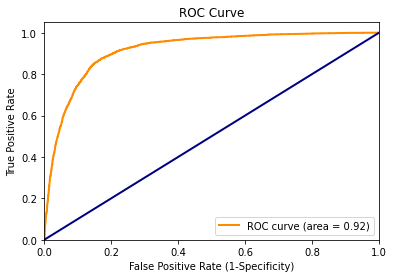

In [43]:
fpr, tpr, thresholds = metrics.roc_curve(both_df['deposit'], both_df['probabilities'], pos_label=1)
roc_auc = auc(fpr, tpr)

%matplotlib inline
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

We now need to predict the category from the probability to default value. We will use grid search to determine the best probability threshold cut-off.

In [44]:
for i in list(np.arange(0, 1, 0.1)):
    both_df["y_predictor"] = 0
    both_df.loc[both_df["probabilities"] > i, 'y_predictor'] = 1
    print ("Threshold", round(i, 2), "Train Accuracy:", round(accuracy_score(both_df['deposit'], both_df['y_predictor']), 4))

Threshold 0.0 Train Accuracy: 0.1115
Threshold 0.1 Train Accuracy: 0.8393
Threshold 0.2 Train Accuracy: 0.894
Threshold 0.3 Train Accuracy: 0.9066
Threshold 0.4 Train Accuracy: 0.9096
Threshold 0.5 Train Accuracy: 0.9076
Threshold 0.6 Train Accuracy: 0.9057
Threshold 0.7 Train Accuracy: 0.9019
Threshold 0.8 Train Accuracy: 0.898
Threshold 0.9 Train Accuracy: 0.8949


We can see that at a threshold of `0.4` we have the highest training accuracy. We will set the threshold at `0.4` for classifying the data.

In [45]:
y_prediction_test_df = pd.DataFrame(logistic_model.predict(sm.add_constant(x_test.drop(columns_to_drop, axis=1))))
y_prediction_test_df.columns = ["probabilities"]
both_test_df = pd.concat([y_test, y_prediction_test_df], axis=1)
both_test_df["y_predictor"] = 0
both_test_df.loc[both_test_df["probabilities"] > 0.5, 'y_predictor'] = 1
print ("Test Confusion Matrix\n", pd.crosstab(both_test_df['deposit'], both_test_df['y_predictor'], rownames=["Actual"], colnames=["Predicted"]))
print ("Test Accuracy:", round(accuracy_score(both_test_df['deposit'], both_test_df['y_predictor']), 4))

Test Confusion Matrix
 Predicted      0    1
Actual               
0          10605  326
1            902  524
Test Accuracy: 0.9006


## Random Forest

We will reuse the dummies we constructed for the logistic regression as well as constructing new dummies for the independent variables that we excluded from our previous model.

In [47]:
marital_dummies = pd.get_dummies(bank_df['marital'], prefix='marital')
education_dummies = pd.get_dummies(bank_df['education'], prefix='education')
housing_dummies = pd.get_dummies(bank_df['housing'], prefix='housing')
loan_dummies = pd.get_dummies(bank_df['loan'], prefix='loan')
day_of_week_dummies = pd.get_dummies(bank_df['day_of_week'], prefix='day_of_week')
# dummies not constructed here were already constructed as part of the logistic regression
bank_rand_forest_df = pd.concat([bank_df[['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 
                                         'cons_conf_idx', 'euribor3m', 'nr_employed', 'deposit']], 
                                job_dummies, marital_dummies, education_dummies, default_dummies, housing_dummies, loan_dummies, 
                                contact_dummies, month_dummies, day_of_week_dummies, poutcome_dummies, client_contacted_dummies], axis=1)
bank_rand_forest_df.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,deposit,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,client_was_contacted_0,client_was_contacted_1
0,44,210,1,0,0,1.4,93.444,-36.1,4.963,5228.1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1,53,138,1,0,0,-0.1,93.200,-42.0,4.021,5195.8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
3,39,185,2,0,0,-1.8,93.075,-47.1,1.405,5099.1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


In [48]:
x_train, x_test, y_train, y_test = train_test_split(bank_rand_forest_df.drop(['deposit'], axis=1), 
                                                    bank_rand_forest_df['deposit'], 
                                                    train_size=0.7,
                                                    random_state=42) # random state set for reproducable results
rand_forest_fit = RandomForestClassifier(n_estimators=1000, 
                                         criterion="gini", 
                                         max_depth=100, 
                                         min_samples_split=3, 
                                         min_samples_leaf=2) # these hyperparameters will need to be tuned
rand_forest_fit.fit(x_train, y_train)
print("Random Forest - Train Confusion Matrix\n", pd.crosstab(y_train, 
                                                              rand_forest_fit.predict(x_train), 
                                                              rownames=["Actual"], 
                                                              colnames=["Predicted"]))
print("Random Forest - Train accuracy", round(accuracy_score(y_train, rand_forest_fit.predict(x_train)), 3))
print("Random Forest - Test Confusion Matrix", pd.crosstab(y_test, 
                                                           rand_forest_fit.predict(x_test), 
                                                           rownames=["Actual"], 
                                                           colnames=["Predicted"]))
print("Random Forest - Test accuracy", round(accuracy_score(y_test, rand_forest_fit.predict(x_test)), 3))

Random Forest - Train Confusion Matrix
 Predicted      0     1
Actual                
0          25546    71
1            576  2638
Random Forest - Train accuracy 0.978
Random Forest - Test Confusion Matrix Predicted      0    1
Actual               
0          10598  333
1            737  689
Random Forest - Test accuracy 0.913


We can see here that the test accuracy of random forest is higher than that of logistic regression. This applies even after removing removing insignificant and multi-colinear variables. We now preform a grid search to tune hyperparameters.

In [49]:
pipeline = Pipeline([('clf', RandomForestClassifier(criterion='gini'))])
parameters = {
    'clf__n_estimators': (200, 300, 500),
    'clf__max_depth': (20, 30, 50),
    'clf__min_samples_split': (2, 3),
    'clf__min_samples_leaf': (1, 2)}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(x_train, y_train)
print('Best Training score: ' + str(grid_search.best_score_))
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(str(param_name) + ': ' + str(best_parameters[param_name]))
    
predictions = grid_search.predict(x_test)
print("Testing accuracy: " + str(accuracy_score(y_test, predictions)))
print("Complete report of Testing data", classification_report(y_test, predictions))
print("Random Forest Grid Search - Test Confusion Matrix", pd.crosstab(y_test, predictions, rownames=["Actual"], colnames=["Predicted"]))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  7.4min finished


Best Training score: 0.9162359233985319
Best parameters set:
clf__max_depth: 20
clf__min_samples_leaf: 2
clf__min_samples_split: 3
clf__n_estimators: 200
Testing accuracy: 0.9114671845917294
Complete report of Testing data               precision    recall  f1-score   support

           0       0.93      0.97      0.95     10931
           1       0.67      0.47      0.55      1426

    accuracy                           0.91     12357
   macro avg       0.80      0.72      0.75     12357
weighted avg       0.90      0.91      0.90     12357

Random Forest Grid Search - Test Confusion Matrix Predicted      0    1
Actual               
0          10594  337
1            757  669


We see here that the random forest model provides better testing accuracy than the logistic regression model however the hyperparameter tuning did not noticably improve the model (test accuracy remains at 0.913).

### Variable Importance

Feature ranking:
Feature 1 , duration 0.32396613308861183
Feature 8 , euribor3m 0.09691302125331946
Feature 9 , nr_employed 0.06561971592991273
Feature 0 , age 0.06065761909976759
Feature 2 , campaign 0.027579628546691107
Feature 3 , pdays 0.027533659170110178
Feature 7 , cons_conf_idx 0.02630051348990021
Feature 6 , cons_price_idx 0.025436900620447487
Feature 5 , emp_var_rate 0.024591808424592625
Feature 64 , client_was_contacted_1 0.022028445005626115
Feature 63 , client_was_contacted_0 0.01815893897498579
Feature 62 , poutcome_success 0.01729101908455374
Feature 4 , previous 0.010599055777961877
Feature 32 , education_university.degree 0.0100552863204758
Feature 39 , housing_yes 0.009799078393856247
Feature 37 , housing_no 0.00977388683361446
Feature 10 , job_admin. 0.009330849450659002
Feature 23 , marital_married 0.009003316874215671
Feature 57 , day_of_week_thu 0.008959539994781452
Feature 56 , day_of_week_mon 0.008935467069925073
Feature 24 , marital_single 0.008641461642728741


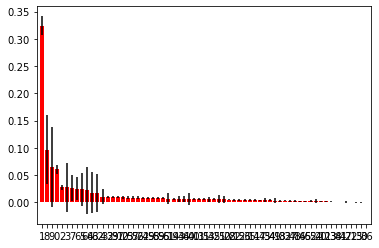

In [50]:
# random forest classifier parameters taken from hyperparameter tuning abaove
random_forest_fit = RandomForestClassifier(n_estimators=500, criterion="gini", max_depth=30, min_samples_split=2, min_samples_leaf=2)
random_forest_fit.fit(x_train, y_train)
importances = random_forest_fit.feature_importances_
standard_deviations = np.std([tree.feature_importances_ for tree in random_forest_fit.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
column_names = list(x_train.columns)

print("Feature ranking:")
for feature in range(x_train.shape[1]):
    print ("Feature", indices[feature], ",", column_names[indices[feature]], importances[indices[feature]])
    
plt.figure()
plt.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=standard_deviations[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

We can see that the variable importance for random forest matches what we got with logistic regression however we need not worry about multi-collinearity in a random forest model.

In [51]:
pickle.dump(grid_search, open(os.path.join('app', 'rand_forest.sav'), 'wb'))